## Analyse the results



In [1]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils
import emcee
import pandas as pd

# access the right directory
#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
import glob
from pl_temp_fit import Emcee_utils
json_files = glob.glob('fit_experimental_emcee_PL/fit_data_base/*.json')
list_model_config=[]
for id,json_file in enumerate(json_files):
    try:
        model_config, model_config_save = config_utils.load_model_config(json_file.split('/')[-1].replace('.json',''), database_folder = "fit_experimental_emcee_PL/fit_data_base")
    except Exception as e:
        print(e)
        continue
    if os.path.exists(model_config_save['save_folder']+'/sampler.h5'):      
        filename = model_config_save['save_folder'] + "/sampler.h5"
        try: 
            reader = Emcee_utils.hDFBackend_2(filename, name="multi_core")
            distribution = reader.get_chain(flat=True)
        except:
            reader = Emcee_utils.hDFBackend_2(filename, name="single_core")
            distribution = reader.get_chain(flat=True)
        true_parameters=list(np.mean(distribution,axis=0))
        model_config_save['mean'] = [f"{x:.3f}" for x in true_parameters]          
        model_config_save['num_iteration'] = reader.iteration  
        log_prob = reader.get_log_prob( flat=True)  
        model_config_save['max_log_prob'] = np.max(log_prob)
        list_model_config.append(model_config_save)

df_all = pd.DataFrame(list_model_config)
df_all.sort_values(by='date',ascending=False,inplace=True)   
df_all

,Temp_std_err,hws_std_err,relative_intensity_std_error_PL,relative_intensity_std_error_EL,sigma,save_folder,csv_name_PL,csv_name_EL,date,test_id,...,params_to_fit_init,min_bounds,max_bounds,num_iteration_max_likelihood,coeff_spread,nsteps,num_coords,mean,num_iteration,max_log_prob
0,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_08_27...,experiemental_data/2023-12-12-Lowtemp-PL/Y6-12...,,2024_08_27,71e8e08a-3e37-4781-bc3a-b15a86ce559b,...,"{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.401, 0.001, 0.079, 0.112, 0.160]",13,-157.826855


In [3]:
index_analyse = 0
test_id = df_all['test_id'].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
filename = model_config_save['save_folder'] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)  

number of iterations 55
-129.31411835046282


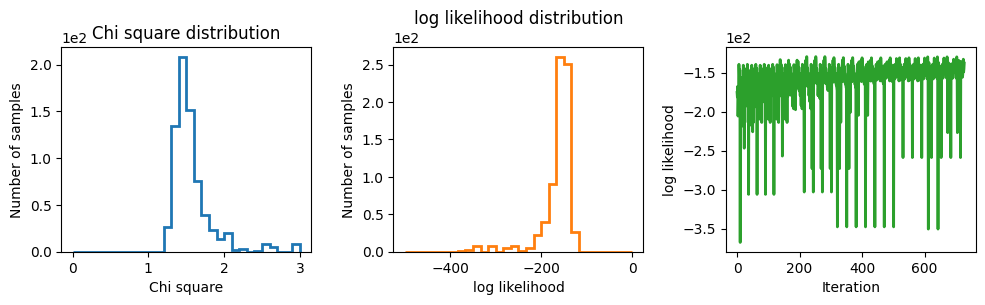

In [10]:
from pl_temp_fit import plot_utils
import importlib
importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(reader,range_log_prior = (-500,0),discard=30,range_chi_square = (0,3),filter_log_likelihood=True)

/media/mohammed/Work/Work/pl_temp_fit/src/pl_temp_fit/plot_utils.py:231: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(samples))
/media/mohammed/Work/Work/pl_temp_fit/src/pl_temp_fit/plot_utils.py:236: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


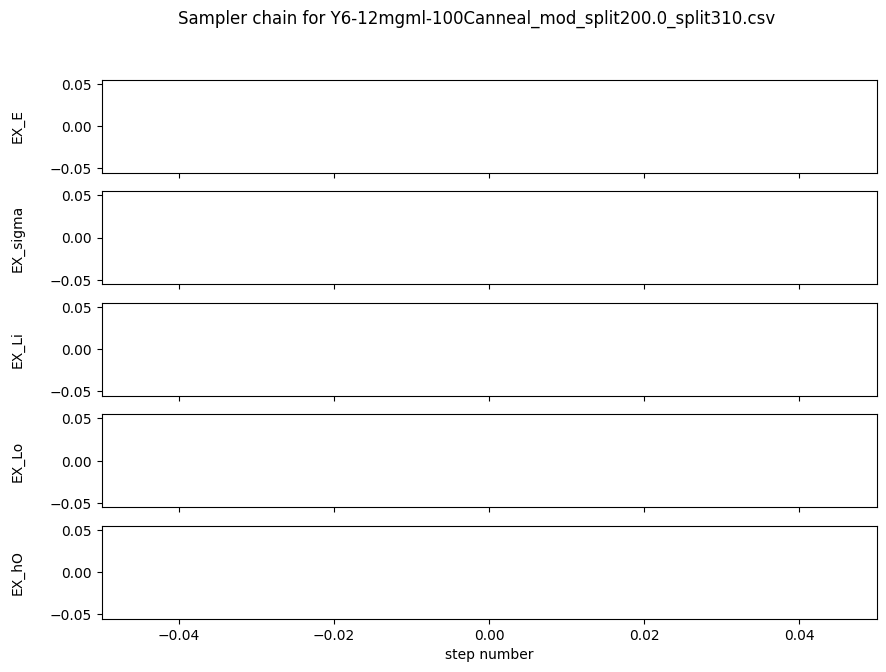

In [11]:
plot_utils.plot_chains(reader,model_config_save,discard=300)

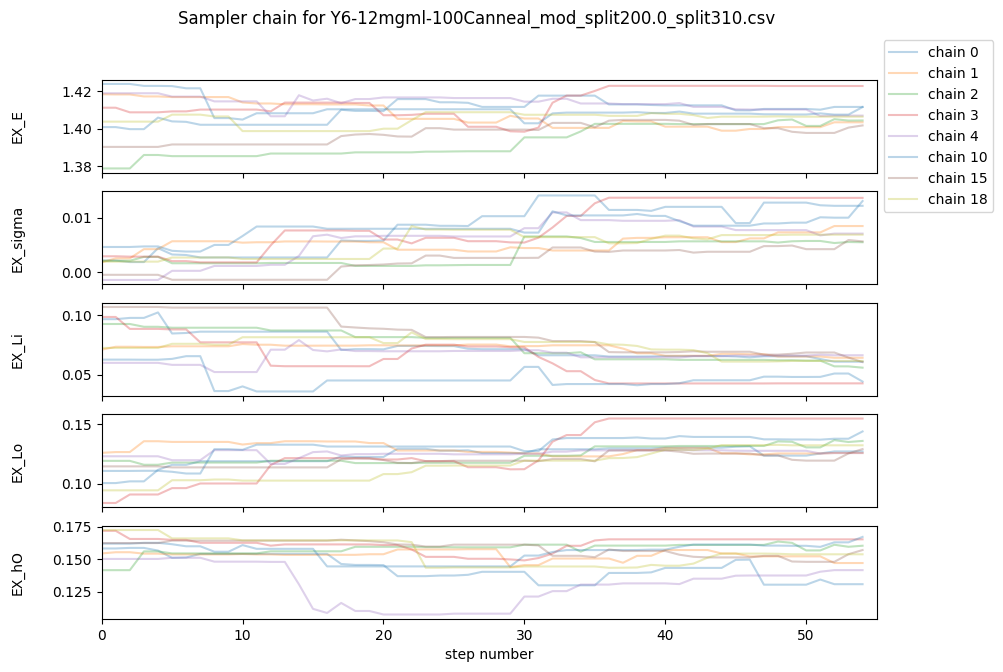

In [9]:
plot_utils.plot_diff_chains(reader,model_config_save,discard=0,chains_list = [0,1,2,3,4,10,15,18])

(1.0, 1.6)

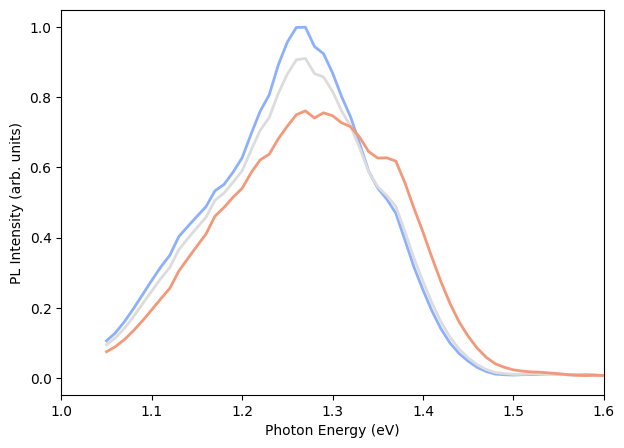

In [7]:
def plot_PL_data(
     truemodel_pl, temperature_list, hws,title="Experimental Data"
):
    fig,ax= plt.subplots(1,1, figsize=(7, 5))

    data_true_plot = truemodel_pl.reshape(len(hws), -1)/max(truemodel_pl.reshape(-1, 1))
    import seaborn as sns
    color_list = sns.color_palette('coolwarm', len(temperature_list))
    for i in range(len(temperature_list)):

        ax.plot(
            hws,
            data_true_plot[:, i],
            label="" + str(temperature_list[i]) + " K",
            #linestyle="--",
            color=color_list[i],
            linewidth=2,
        )


    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")

    return fig,ax
csv_name = model_config_save["csv_name_PL"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = plot_PL_data(Exp_data, temperature_list, hws,title="Experimental Data")
ax.set_xlim(1, 1.6)

In [8]:
plot_utils.plot_fit_to_experimental_data(model_config_save,model_config,reader,discard=60,filter_log_likelihood=True)

ValueError: max() arg is an empty sequence

(<Figure size 1000x700 with 5 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: ylabel='EX_hO'>], dtype=object))

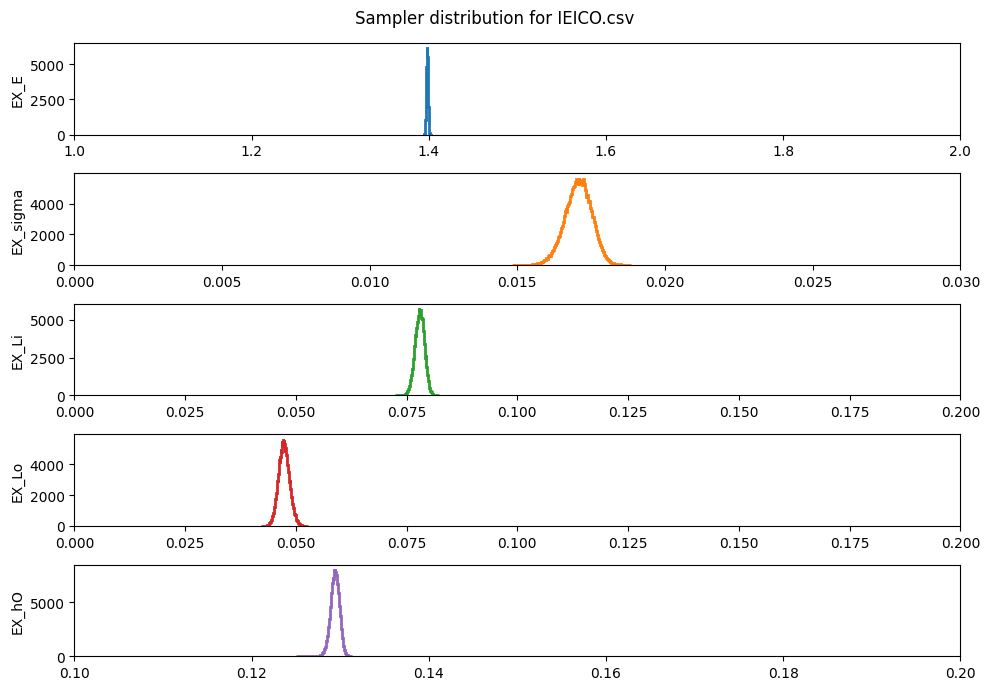

In [ ]:
importlib.reload(plot_utils)
plot_utils.plot_distribution(reader,model_config_save,discard=400,filter_log_likelihood=True)

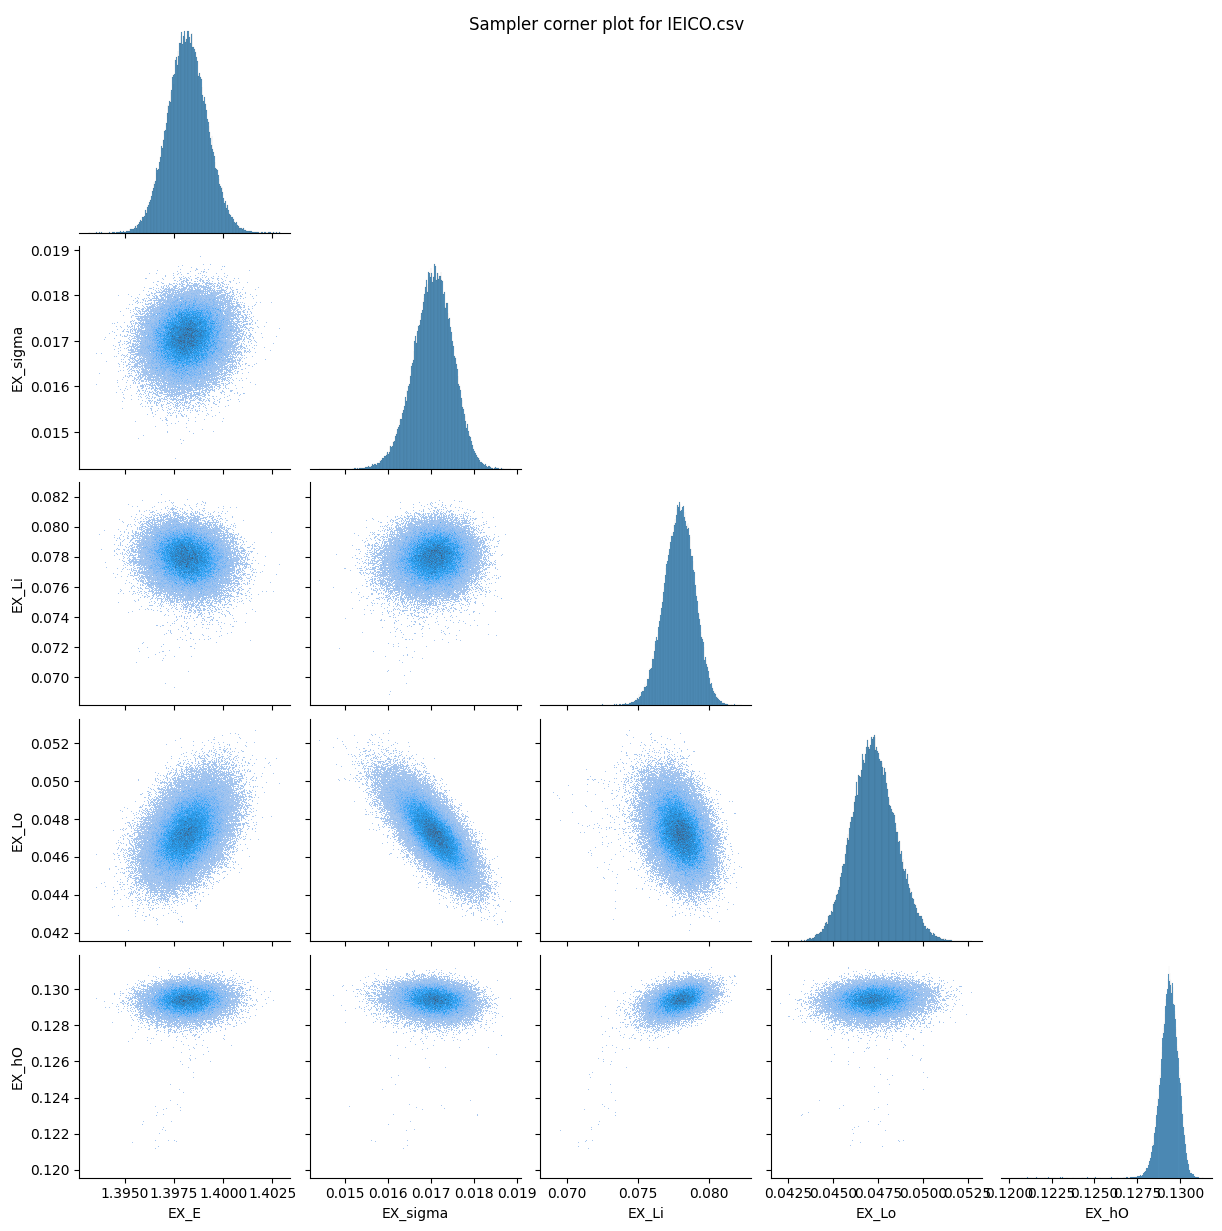

In [ ]:
plot_utils.plot_corner(reader,model_config_save,discard=200,filter_log_likelihood=True)

number of iterations 681


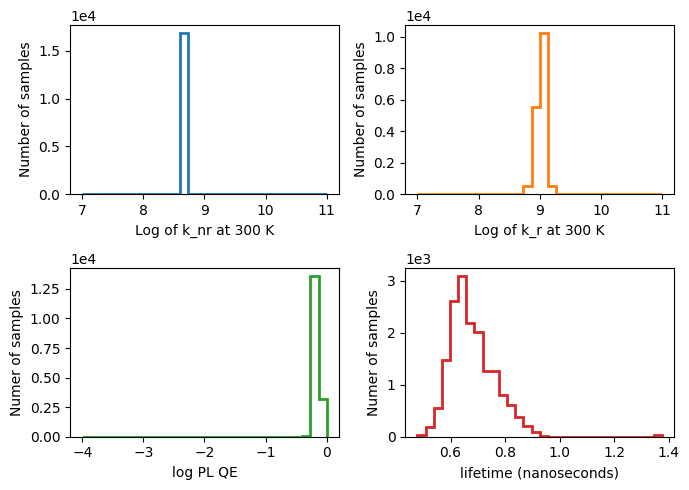

In [ ]:
plot_utils.plot_lifetime(reader, discard=100,filter_log_likelihood=True)

number of iterations 1210
-79.13905769350092
number of iterations 793
-308.2626075644732


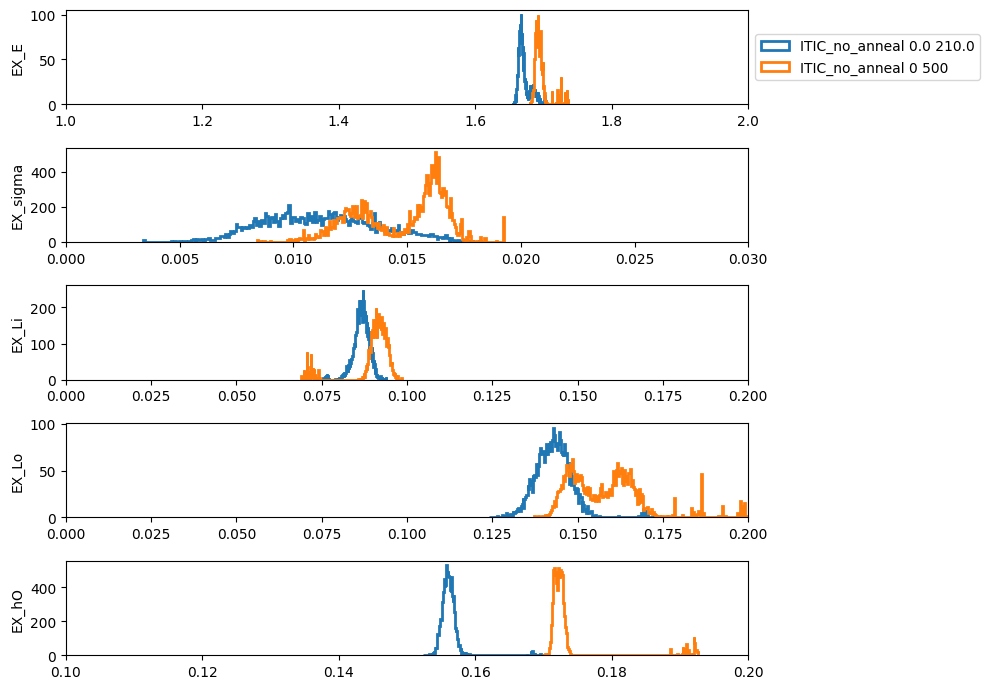

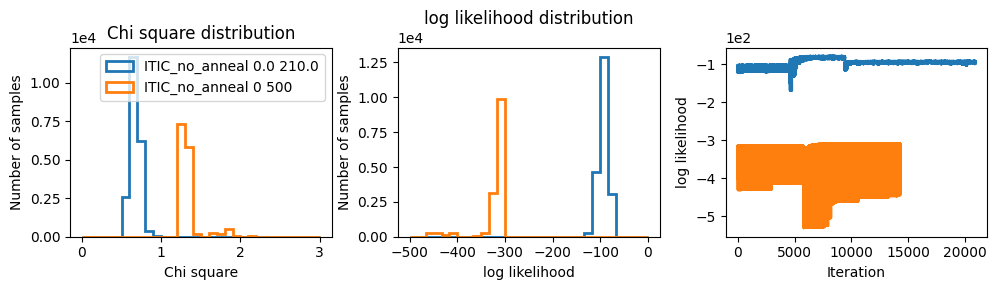

In [ ]:
import importlib

importlib.reload(plot_utils)
index_analyse_list = [7, 9]
fig, axes = plt.subplots(5, figsize=(10, 7))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_PL"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_PL/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_distribution_multi(
        reader,
        model_config_save,
        discard=300,
        filter_log_likelihood=True,
        fig=fig,
        axes=axes,
        color=f"C{i}",
        legend_label=label,
    )
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_PL"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_PL/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_fit_statistics_multi(
        reader,
        range_log_prior=(-500, 0),
        discard=300,
        range_chi_square=(0, 3),
        filter_log_likelihood=True,
        fig=fig,
        ax=ax,
        legend_label=label,
        color=f"C{i}",
    )